# GAN

In [1]:
%matplotlib inline
from __future__ import print_function
import random
import imageio
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import time
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2


manualSeed = 0
random.seed(manualSeed)
torch.manual_seed(manualSeed)


In [2]:
# 图片路径的上一级
dataroot = "data/"

# 线程数
workers = 2

# 批次大小
batch_size = 128

# 图片尺寸
image_size = 32

# 通道数（RGB）
nc = 3

# Size of generator input
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# epochs数
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

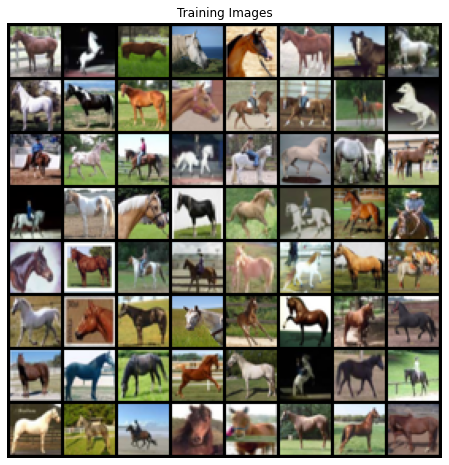

In [3]:
# 读取数据集
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# 创建数据集迭代器
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# 判断是否使用GPU
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 展示部分训练图像
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# 辅助函数
def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    RGB = 255 * (image - image.min()) / (image.max()-image.min())
    RGB = RGB.astype('uint8')
    
    return cv2.imwrite(path, RGB)  # 保存图像文件

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

class argparse():
    pass

args = argparse()
args.epoch, args.lrG, args.lrD = [500, 0.0002, 0.002]
args.batch_size = 128
args.save_dir = 'model/'
args.result_dir = 'results/'
args.log_dir = 'logs/'
args.gpu_mode = True
args.dataset = 'cifar10'
args.input_size = 32
args.beta1 = 0.5
args.beta2 = 0.999

In [5]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

class GAN(object):
    def __init__(self, args):
        # parameters
        self.epoch = args.epoch
        self.sample_num = 100
        self.batch_size = args.batch_size
        self.save_dir = args.save_dir
        self.result_dir = args.result_dir
        self.dataset = args.dataset
        self.log_dir = args.log_dir
        self.gpu_mode = args.gpu_mode
        self.input_size = args.input_size
        self.z_dim = 62
        self.model_name = args.model_name

        # load dataset
        self.data_loader = dataloader
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=args.lrG, betas=(args.beta1, args.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=args.lrD, betas=(args.beta1, args.beta2))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()
            self.BCE_loss = nn.BCELoss().cuda()
        else:
            self.BCE_loss = nn.BCELoss()



        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()


    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_ = sample_z_.cuda()

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

training start!!
Avg one epoch time: 1.21, total 500 epochs time: 613.45


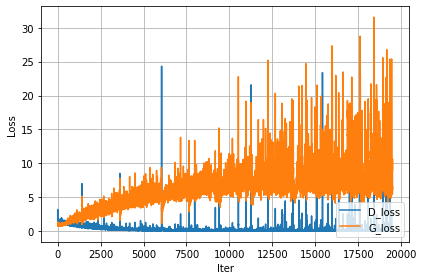

Training finished!


In [6]:
args.model_name = 'GAN'
gan = GAN(args)
gan.train()
print("Training finished!")

In [12]:
batch_size = 1000
latent_size = 62
img_size = 32
fixed_noise = torch.randn(batch_size, latent_size)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = gan.G(fixed_noise)



save_imgs = fake_images.cpu().detach().numpy()

for i in range(1000):
    file = 'outputs/'+str(i)+'.png'
    RGB = np.zeros((img_size, img_size, 3))
    RGB[:,:,0] = save_imgs[i][2]
    RGB[:,:,1] = save_imgs[i][1]
    RGB[:,:,2] = save_imgs[i][0]

    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    RGB = RGB.astype('uint8')
    cv2.imwrite(file, RGB)  # 保存图像文件

# DCGAN

In [43]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [44]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)

In [45]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [50]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, 
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/500]	Loss_D: 0.7812	Loss_G: 1.9374	D(x): 0.8426	D(G(z)): 0.3351 / 0.2058
[1/500]	Loss_D: 0.4056	Loss_G: 2.7248	D(x): 0.7968	D(G(z)): 0.1316 / 0.0941
[2/500]	Loss_D: 0.8080	Loss_G: 4.8321	D(x): 0.9600	D(G(z)): 0.4532 / 0.0127
[3/500]	Loss_D: 0.7599	Loss_G: 4.3181	D(x): 0.9454	D(G(z)): 0.4210 / 0.0212
[4/500]	Loss_D: 0.3738	Loss_G: 3.4253	D(x): 0.8895	D(G(z)): 0.2024 / 0.0454
[5/500]	Loss_D: 0.7056	Loss_G: 4.6873	D(x): 0.9289	D(G(z)): 0.4079 / 0.0150
[6/500]	Loss_D: 1.0063	Loss_G: 4.5035	D(x): 0.8816	D(G(z)): 0.4366 / 0.0192
[7/500]	Loss_D: 0.7402	Loss_G: 1.2098	D(x): 0.6167	D(G(z)): 0.1371 / 0.3891
[8/500]	Loss_D: 1.3307	Loss_G: 5.7719	D(x): 0.9645	D(G(z)): 0.5890 / 0.0056
[9/500]	Loss_D: 0.9696	Loss_G: 5.9530	D(x): 0.9825	D(G(z)): 0.5248 / 0.0060
[10/500]	Loss_D: 0.3985	Loss_G: 3.1513	D(x): 0.8759	D(G(z)): 0.2125 / 0.0546
[11/500]	Loss_D: 0.4106	Loss_G: 2.7458	D(x): 0.8381	D(G(z)): 0.1548 / 0.1007
[12/500]	Loss_D: 0.2438	Loss_G: 4.3266	D(x): 0.8837	D(G(z)):

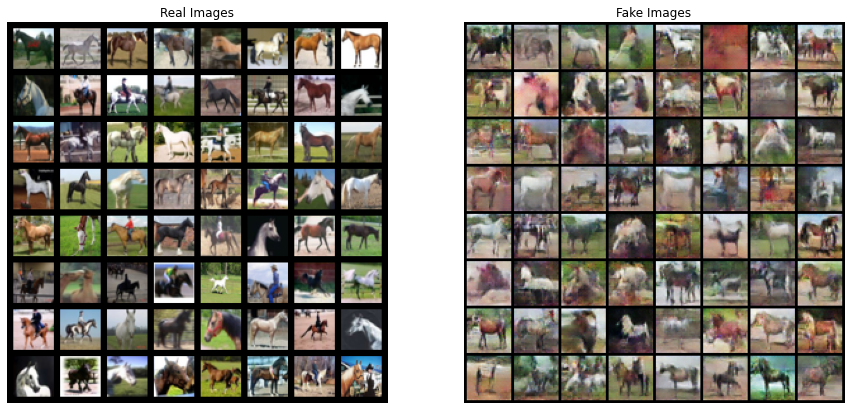

In [51]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [55]:
batch_size = 1000
latent_size = 100
img_size = 32
fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = netG(fixed_noise)



save_imgs = fake_images.cpu().detach().numpy()

for i in range(1000):
    file = 'outputs/'+str(i)+'.png'
    RGB = np.zeros((img_size, img_size, 3))
    RGB[:,:,0] = save_imgs[i][2]
    RGB[:,:,1] = save_imgs[i][1]
    RGB[:,:,2] = save_imgs[i][0]

    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    RGB = RGB.astype('uint8')
    cv2.imwrite(file, RGB)  # 保存图像文件

# WGAN

In [19]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            # nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

class WGAN(object):
    def __init__(self, args):
        # parameters
        self.epoch = args.epoch
        self.sample_num = 100
        self.batch_size = args.batch_size
        self.save_dir = args.save_dir
        self.result_dir = args.result_dir
        self.dataset = args.dataset
        self.log_dir = args.log_dir
        self.gpu_mode = args.gpu_mode
        self.model_name = args.gan_type
        self.input_size = args.input_size
        self.z_dim = 62
        self.c = 0.01                   # clipping value
        self.n_critic = 5               # the number of iterations of the critic per generator iteration

        # load dataset
        self.data_loader = dataloader
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=args.lrG, betas=(args.beta1, args.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=args.lrD, betas=(args.beta1, args.beta2))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()


        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                D_loss = D_real_loss + D_fake_loss

                D_loss.backward()
                self.D_optimizer.step()

                # clipping D
                for p in self.D.parameters():
                    p.data.clamp_(-self.c, self.c)

                if ((iter+1) % self.n_critic) == 0:
                    # update G network
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)
                    self.train_hist['G_loss'].append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    self.train_hist['D_loss'].append(D_loss.item())

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_ = sample_z_.cuda()

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')


training start!!
Avg one epoch time: 1.10, total 500 epochs time: 560.42
Training finish!... save training results


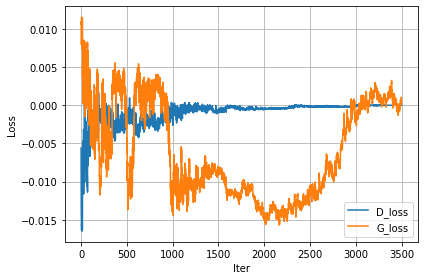

Training finished!


In [20]:
args.gan_type = 'WGAN'
gan = WGAN(args)
gan.train()
print("Training finished!")

In [22]:
batch_size = 1000
latent_size = 62
img_size = 32
fixed_noise = torch.randn(batch_size, latent_size)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = gan.G(fixed_noise)



save_imgs = fake_images.cpu().detach().numpy()

for i in range(1000):
    file = 'outputs/'+str(i)+'.png'
    RGB = np.zeros((img_size, img_size, 3))
    RGB[:,:,0] = save_imgs[i][2]
    RGB[:,:,1] = save_imgs[i][1]
    RGB[:,:,2] = save_imgs[i][0]

    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    RGB = RGB.astype('uint8')
    cv2.imwrite(file, RGB)  # 保存图像文件

# LSGAN

In [27]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            # nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

class LSGAN(object):
    def __init__(self, args):
        # parameters
        self.epoch = args.epoch
        self.sample_num = 100
        self.batch_size = args.batch_size
        self.save_dir = args.save_dir
        self.result_dir = args.result_dir
        self.dataset = args.dataset
        self.log_dir = args.log_dir
        self.gpu_mode = args.gpu_mode
        self.model_name = args.gan_type
        self.input_size = args.input_size
        self.z_dim = 62

        # load dataset
        self.data_loader = dataloader
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=args.lrG, betas=(args.beta1, args.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=args.lrD, betas=(args.beta1, args.beta2))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()
            self.MSE_loss = nn.MSELoss().cuda()
        else:
            self.MSE_loss = nn.MSELoss()

      
        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.MSE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.MSE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.MSE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_ = sample_z_.cuda()

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')


training start!!
Avg one epoch time: 1.25, total 500 epochs time: 634.06
Training finish!... save training results


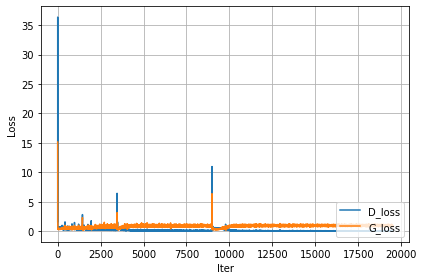

Training finished!


In [28]:
args.gan_type = 'LSGAN'
gan = LSGAN(args)
gan.train()
print("Training finished!")

In [29]:
batch_size = 1000
latent_size = 62
img_size = 32
fixed_noise = torch.randn(batch_size, latent_size)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = gan.G(fixed_noise)



save_imgs = fake_images.cpu().detach().numpy()

for i in range(1000):
    file = 'outputs/'+str(i)+'.png'
    RGB = np.zeros((img_size, img_size, 3))
    RGB[:,:,0] = save_imgs[i][2]
    RGB[:,:,1] = save_imgs[i][1]
    RGB[:,:,2] = save_imgs[i][0]

    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    RGB = RGB.astype('uint8')
    cv2.imwrite(file, RGB)  # 保存图像文件

# DRAGAN

In [30]:
from torch.autograd import grad
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

class DRAGAN(object):
    def __init__(self, args):
        # parameters
        self.epoch = args.epoch
        self.sample_num = 100
        self.batch_size = args.batch_size
        self.save_dir = args.save_dir
        self.result_dir = args.result_dir
        self.dataset = args.dataset
        self.log_dir = args.log_dir
        self.gpu_mode = args.gpu_mode
        self.model_name = args.gan_type
        self.input_size = args.input_size
        self.z_dim = 62
        self.lambda_ = 0.25

        # load dataset
        self.data_loader = dataloader
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=args.lrG, betas=(args.beta1, args.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=args.lrD, betas=(args.beta1, args.beta2))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()
            self.BCE_loss = nn.BCELoss().cuda()
        else:
            self.BCE_loss = nn.BCELoss()

     
        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            epoch_start_time = time.time()
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                """ DRAGAN Loss (Gradient penalty) """
                # This is borrowed from https://github.com/kodalinaveen3/DRAGAN/blob/master/DRAGAN.ipynb
                alpha = torch.rand(self.batch_size, 1, 1, 1).cuda()
                if self.gpu_mode:
                    alpha = alpha.cuda()
                    x_p = x_ + 0.5 * x_.std() * torch.rand(x_.size()).cuda()
                else:
                    x_p = x_ + 0.5 * x_.std() * torch.rand(x_.size())
                differences = x_p - x_
                interpolates = x_ + (alpha * differences)
                interpolates.requires_grad = True
                pred_hat = self.D(interpolates)
                if self.gpu_mode:
                    gradients = grad(outputs=pred_hat, inputs=interpolates, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
                else:
                    gradients = grad(outputs=pred_hat, inputs=interpolates, grad_outputs=torch.ones(pred_hat.size()),
                         create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty
                self.train_hist['D_loss'].append(D_loss.item())
                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)

                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name, self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_ = sample_z_.cuda()

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                    self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')


training start!!
Avg one epoch time: 1.78, total 500 epochs time: 897.26
Training finish!... save training results


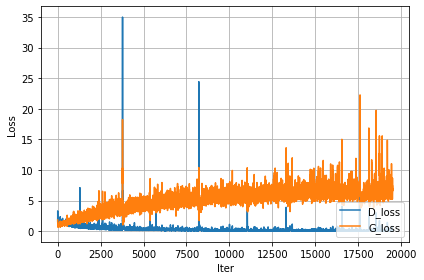

Training finished!


In [31]:
args.gan_type = 'DRAGAN'
gan = DRAGAN(args)
gan.train()
print("Training finished!")

In [32]:
batch_size = 1000
latent_size = 62
img_size = 32
fixed_noise = torch.randn(batch_size, latent_size)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = gan.G(fixed_noise)



save_imgs = fake_images.cpu().detach().numpy()

for i in range(1000):
    file = 'outputs/'+str(i)+'.png'
    RGB = np.zeros((img_size, img_size, 3))
    RGB[:,:,0] = save_imgs[i][2]
    RGB[:,:,1] = save_imgs[i][1]
    RGB[:,:,2] = save_imgs[i][0]

    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    RGB = RGB.astype('uint8')
    cv2.imwrite(file, RGB)  # 保存图像文件

# BEGAN

In [33]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):
    # It must be Auto-Encoder style architecture
    # Architecture : (64)4c2s-FC32-FC64*14*14_BR-(1)4dc2s_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * (self.input_size // 2) * (self.input_size // 2), 32),
            nn.Linear(32, 64 * (self.input_size // 2) * (self.input_size // 2)),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            #nn.Sigmoid(),
        )

        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        x = x.view(-1, 64, (self.input_size // 2), (self.input_size // 2))
        x = self.deconv(x)

        return x

class BEGAN(object):
    def __init__(self, args):
        # parameters
        self.epoch = args.epoch
        self.sample_num = 100
        self.batch_size = args.batch_size
        self.save_dir = args.save_dir
        self.result_dir = args.result_dir
        self.dataset = args.dataset
        self.log_dir = args.log_dir
        self.gpu_mode = args.gpu_mode
        self.model_name = args.gan_type
        self.input_size = args.input_size
        self.z_dim = 62
        self.gamma = 1
        self.lambda_ = 0.001
        self.k = 0.0
        self.lr_lower_boundary = 0.00002

        # load dataset
        self.data_loader = dataloader
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=0.0002, betas=(args.beta1, args.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=0.0002, betas=(args.beta1, args.beta2))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()

        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []
        self.M = {}
        self.M['pre'] = []
        self.M['pre'].append(1)
        self.M['cur'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))

                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = torch.mean(torch.abs(D_real - x_))

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(torch.abs(D_fake - G_))

                D_loss = D_real_loss - self.k * D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(torch.abs(D_fake - G_))

                G_loss = D_fake_loss
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                # convergence metric
                temp_M = D_real_loss + torch.abs(self.gamma * D_real_loss - G_loss)

                # operation for updating k
                temp_k = self.k + self.lambda_ * (self.gamma * D_real_loss - G_loss)
                temp_k = temp_k.item()

                self.k = min(max(temp_k, 0), 1)
                self.M['cur'] = temp_M.item()

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f, M: %.8f, k: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item(), self.M['cur'], self.k))


            # if epoch == 0:
            #     self.M['pre'] = self.M['cur']
            #     self.M['cur'] = []
            # else:
            if np.mean(self.M['pre']) < np.mean(self.M['cur']):
                pre_lr = self.G_optimizer.param_groups[0]['lr']
                self.G_optimizer.param_groups[0]['lr'] = max(self.G_optimizer.param_groups[0]['lr'] / 2.0,
                                                             self.lr_lower_boundary)
                self.D_optimizer.param_groups[0]['lr'] = max(self.D_optimizer.param_groups[0]['lr'] / 2.0,
                                                             self.lr_lower_boundary)
                print('M_pre: ' + str(np.mean(self.M['pre'])) + ', M_cur: ' + str(
                    np.mean(self.M['cur'])) + ', lr: ' + str(pre_lr) + ' --> ' + str(
                    self.G_optimizer.param_groups[0]['lr']))
            else:
                print('M_pre: ' + str(np.mean(self.M['pre'])) + ', M_cur: ' + str(np.mean(self.M['cur'])))
                self.M['pre'] = self.M['cur']

                self.M['cur'] = []

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_ = sample_z_.cuda()

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')


training start!!
M_pre: 1.0, M_cur: 0.5673788785934448
M_pre: 0.5673788785934448, M_cur: 0.4818759560585022
M_pre: 0.4818759560585022, M_cur: 0.4477021098136902
M_pre: 0.4477021098136902, M_cur: 0.42006489634513855
M_pre: 0.42006489634513855, M_cur: 0.38945531845092773
M_pre: 0.38945531845092773, M_cur: 0.3781079649925232
M_pre: 0.3781079649925232, M_cur: 0.33890828490257263
M_pre: 0.33890828490257263, M_cur: 0.3195936679840088
M_pre: 0.3195936679840088, M_cur: 0.27361226081848145
M_pre: 0.27361226081848145, M_cur: 0.20528781414031982
M_pre: 0.20528781414031982, M_cur: 0.2119961678981781, lr: 0.0002 --> 0.0001
M_pre: 0.20528781414031982, M_cur: 0.3103615641593933, lr: 0.0001 --> 5e-05
M_pre: 0.20528781414031982, M_cur: 0.3265715539455414, lr: 5e-05 --> 2.5e-05
M_pre: 0.20528781414031982, M_cur: 0.3480440080165863, lr: 2.5e-05 --> 2e-05
M_pre: 0.20528781414031982, M_cur: 0.33036094903945923, lr: 2e-05 --> 2e-05
M_pre: 0.20528781414031982, M_cur: 0.34000635147094727, lr: 2e-05 --> 2e-05


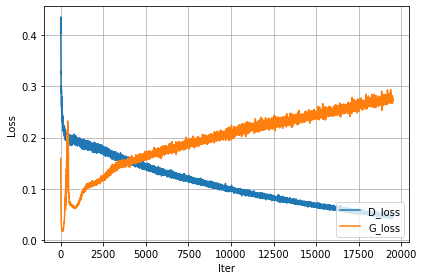

Training finished!


In [34]:
args.gan_type = 'BEGAN'
gan = BEGAN(args)
gan.train()
print("Training finished!")

In [35]:
batch_size = 1000
latent_size = 62
img_size = 32
fixed_noise = torch.randn(batch_size, latent_size)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = gan.G(fixed_noise)



save_imgs = fake_images.cpu().detach().numpy()

for i in range(1000):
    file = 'outputs/'+str(i)+'.png'
    RGB = np.zeros((img_size, img_size, 3))
    RGB[:,:,0] = save_imgs[i][2]
    RGB[:,:,1] = save_imgs[i][1]
    RGB[:,:,2] = save_imgs[i][0]

    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    RGB = RGB.astype('uint8')
    cv2.imwrite(file, RGB)  # 保存图像文件

# styleGAN

In [1]:
# 配置环境
!sh setup.sh

Looking in indexes: https://mirrors.aliyun.com/pypi/simple, https://download.pytorch.org/whl/lts/1.8/cu111
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
/usr/local/lib/python3.8/dist-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
installing mmcv-full from wheel.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.8.0/index.html
  Using cached https://download.openmmlab.com/mmcv/dist/cu111/torch1.8.0/mmcv_full-1.5.2-cp38-cp38-manylinux1_x86_64.whl (44.9 MB)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
  Using cached mmcv_full-1.5.0-cp38-cp38-linux_x86_64.whl
  Attempting uninstall: mmcv-full
    Found existing installation: mmcv-full 1.5.2
    Uninstalling mmcv-full-1.5.2:
      Successfully uninstalled mmcv-full-1.5.2


### 训练用于 FID 评估指标的 Inception V3 模型

生成 `work_dirs/inception_pkl/horse.pkl` 文件

In [4]:
!python tools/utils/inception_stat.py \
        --imgsdir data/ \
        --pklname horse.pkl \
        --size 32 \
        --flip \
        --num-samples -1

2022-06-15 11:32:26,611 - mmgen - INFO - dataset_name: <class 'mmgen.datasets.unconditional_image_dataset.UnconditionalImageDataset'>, total 7000 images in imgs_root: data/
/usr/local/lib/python3.8/dist-packages/torchvision/models/inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '
2022-06-15 11:32:34,288 - mmgen - INFO - Use all samples in subset
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 280/280, 27.8 task/s, elapsed: 10s, ETA:     0s
2022-06-15 11:32:45,615 - mmgen - INFO - Extract 7000 features


### 配置 config 文件
config/styleganv3/stylegan3.py 
修改imgs_root = 'data/' 到对应的路径 <br>
inception_pkl = 'work_dirs/inception_pkl/horse.pkl' 也需做对应修改

## 训练模型

训练过程中，在 work_dirs/experiments/experiments_name目录下

training_samples保存了训练过程中达到不同迭代次数时的训练效果

ckpt/experiments_name保存了训练过程中达到不同迭代次数时的模型权重文件

命令行中的数字代表使用的显卡数

In [5]:
!bash tools/dist_train.sh configs/styleganv3/stylegan3.py 1 --work-dir work_dirs/experiments/stylegan

tools/train.py:97: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
tools/train.py:107: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
2022-06-15 11:33:59,062 - mmgen - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.8.10 (default, Mar 15 2022, 12:22:08) [GCC 9.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.3.r11.3/compiler.29920130_0
GPU 0: NVIDIA GeForce RTX 3090
GCC: gcc (Ubuntu 

### 生成图像差值视频

In [7]:
!python apps/interpolate_sample.py configs/styleganv3/stylegan3.py work_dirs/experiments/stylegan/best_fid_iter_120000.pth --export-video --samples-path work_dirs/demos/ --endpoint 6 --interval 60 --space z --seed 0 --sample-cfg truncation=0.8

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sputils.py:16: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.8/dist-packages/scipy/linalg/__init__.py:217: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
/usr/local/lib/python3.8/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behav

### 展示并保存一千张图片

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sputils.py:16: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.8/dist-packages/scipy/linalg/__init__.py:217: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
/usr/local/lib/python3.8/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behav

load checkpoint from local path: work_dirs/experiments/stylegan/best_fid_iter_120000.pth
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


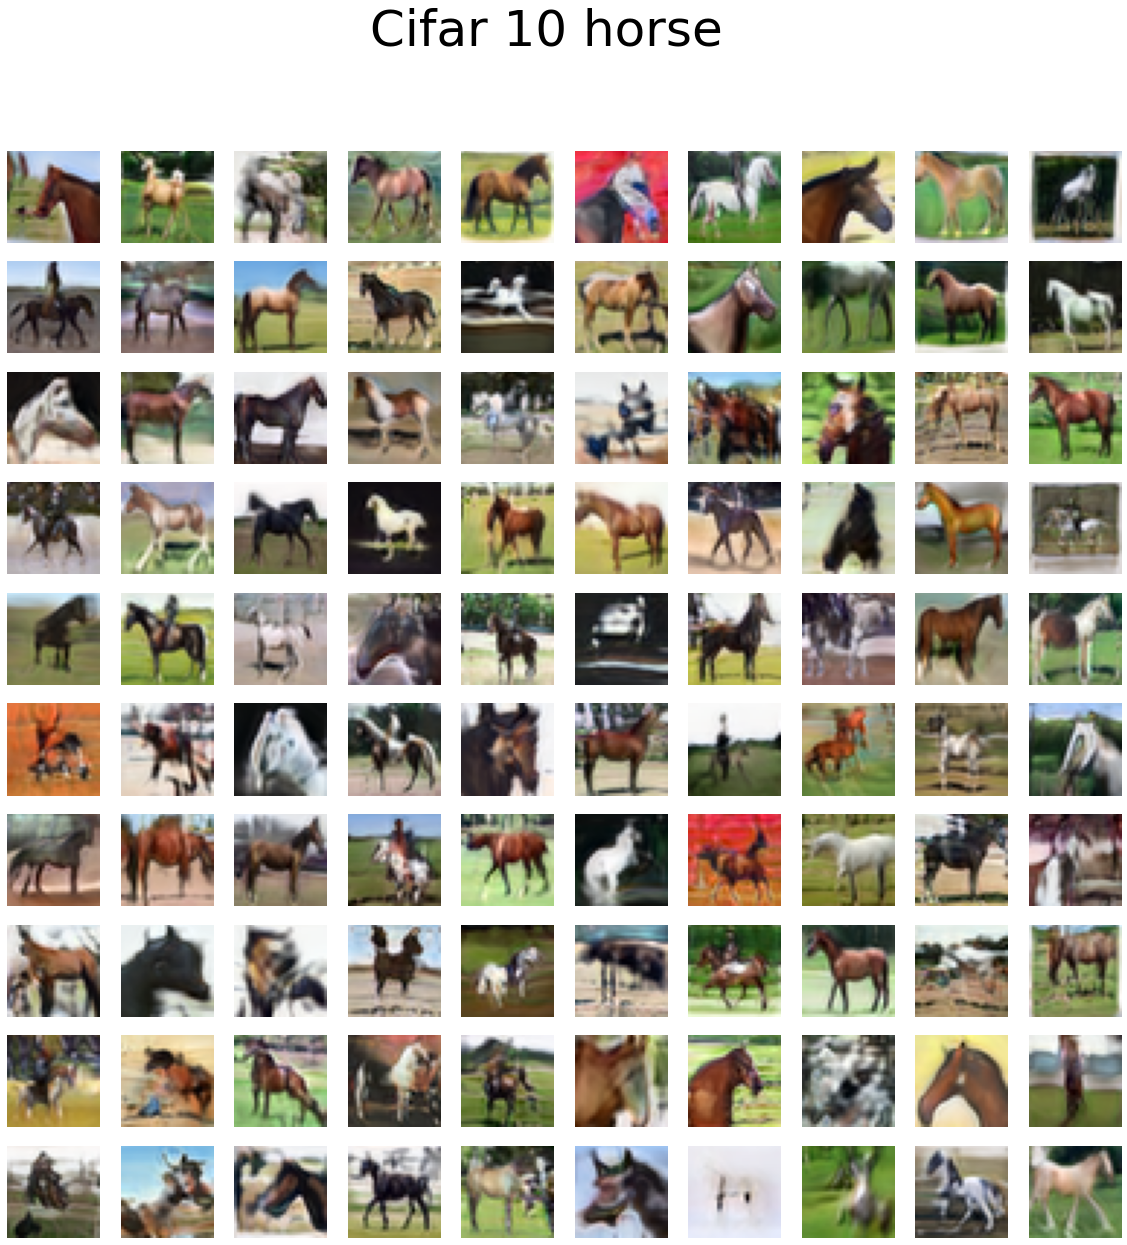

In [8]:
# 导入mmcv和mmgeneration
import mmcv
from mmgen.apis import init_model, sample_unconditional_model

# 导入numpy和matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 指定config文件路径
config_file = 'configs/styleganv3/stylegan3.py'

# 指定预训练模型权重文件路径
checkpoint_file = 'work_dirs/experiments/stylegan/best_fid_iter_120000.pth'

# 输出图像宽高像素尺寸
img_size = 32

# 初始化generatvie
model = init_model(config_file, checkpoint_file, device='cuda:0')

# 生成 n的平方 张图像
n = 10

# 生成图像
fake_imgs = sample_unconditional_model(model, n*n)
def show_fake_img(index):
    '''输入索引号，展示对应的图像'''

    # 分别抽取RGB三通道图像，归一化为0-255的uint8自然图像
    RGB = np.zeros((img_size,img_size,3))
    RGB[:,:,0] = fake_imgs[index][2]
    RGB[:,:,1] = fake_imgs[index][1]
    RGB[:,:,2] = fake_imgs[index][0]

    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    RGB = RGB.astype('uint8')
    return RGB
#     plt.imshow(RGB)
#     plt.show()
fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, figsize=(20,20))
for i in range(n*n):
    axes[i//n, i%n].imshow(show_fake_img(i))
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
fig.suptitle('Cifar 10 horse',fontsize=50)
plt.show()
save_imgs = sample_unconditional_model(model, 1000)
# 保存一千张生成的图片
# 将torch张量转为numpy的array
save_imgs = save_imgs.numpy()
import cv2
for i in range(1000):
    file = 'outputs/'+str(i)+'.png'
    RGB = np.zeros((img_size, img_size, 3))
    RGB[:,:,0] = save_imgs[i][2]
    RGB[:,:,1] = save_imgs[i][1]
    RGB[:,:,2] = save_imgs[i][0]

    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    RGB = RGB.astype('uint8')
    cv2.imwrite(file, RGB)  # 保存图像文件


# FID计算

In [2]:
from fid_score.fid_score import FidScore
import torch

paths = [r'C:\Users\User\Downloads\cifar10_horse\train', r'C:\Users\User\Downloads\Generate']

device = torch.device('cuda:0')

batch_size = 16

fid = FidScore(paths, device, batch_size)

score = fid.calculate_fid_score()

print(score)


  0%|          | 0/313 [00:00<?, ?it/s]

Present batch 1/16

  0%|          | 1/313 [00:02<12:37,  2.43s/it]

done
Present batch 17/16

  1%|          | 2/313 [00:02<05:33,  1.07s/it]

done
Present batch 33/16

  1%|          | 3/313 [00:02<03:18,  1.56it/s]

done
Present batch 49/16

  1%|▏         | 4/313 [00:02<02:15,  2.28it/s]

done
Present batch 65/16

  2%|▏         | 5/313 [00:02<01:40,  3.06it/s]

done
Present batch 81/16

  2%|▏         | 6/313 [00:03<01:19,  3.86it/s]

done
Present batch 97/16

  2%|▏         | 7/313 [00:03<01:06,  4.63it/s]

done
Present batch 113/16

  3%|▎         | 8/313 [00:03<00:57,  5.33it/s]

done
Present batch 129/16

  3%|▎         | 9/313 [00:03<00:51,  5.94it/s]

done
Present batch 145/16

  3%|▎         | 10/313 [00:03<00:46,  6.45it/s]

done
Present batch 161/16

  4%|▎         | 11/313 [00:03<00:43,  6.90it/s]

done
Present batch 177/16

  4%|▍         | 12/313 [00:03<00:41,  7.21it/s]

done
Present batch 193/16

  4%|▍         | 13/313 [00:03<00:40,  7.42it/s]

done
Present batch 209/16

  4%|▍         | 14/313 [00:04<00:39,  7.55it/s]

done
Present batch 225/16

  5%|▍         | 15/313 [00:04<00:38,  7.73it/s]

done
Present batch 241/16

  5%|▌         | 16/313 [00:04<00:37,  7.82it/s]

done
Present batch 257/16

  5%|▌         | 17/313 [00:04<00:37,  7.90it/s]

done
Present batch 273/16

  6%|▌         | 18/313 [00:04<00:37,  7.97it/s]

done
Present batch 289/16

  6%|▌         | 19/313 [00:04<00:36,  8.05it/s]

done
Present batch 305/16

  6%|▋         | 20/313 [00:04<00:36,  8.07it/s]

done
Present batch 321/16

  7%|▋         | 21/313 [00:04<00:36,  8.03it/s]

done
Present batch 337/16

  7%|▋         | 22/313 [00:05<00:36,  8.00it/s]

done
Present batch 353/16

  7%|▋         | 23/313 [00:05<00:36,  7.92it/s]

done
Present batch 369/16

  8%|▊         | 24/313 [00:05<00:36,  7.97it/s]

done
Present batch 385/16

  8%|▊         | 25/313 [00:05<00:36,  7.96it/s]

done
Present batch 401/16

  8%|▊         | 26/313 [00:05<00:35,  7.97it/s]

done
Present batch 417/16

  9%|▊         | 27/313 [00:05<00:35,  8.01it/s]

done
Present batch 433/16

  9%|▉         | 28/313 [00:05<00:35,  8.03it/s]

done
Present batch 449/16

  9%|▉         | 29/313 [00:05<00:35,  8.06it/s]

done
Present batch 465/16

 10%|▉         | 30/313 [00:06<00:35,  8.04it/s]

done
Present batch 481/16

 10%|▉         | 31/313 [00:06<00:34,  8.07it/s]

done
Present batch 497/16

 10%|█         | 32/313 [00:06<00:34,  8.05it/s]

done
Present batch 513/16

 11%|█         | 33/313 [00:06<00:34,  8.08it/s]

done
Present batch 529/16

 11%|█         | 34/313 [00:06<00:34,  8.11it/s]

done
Present batch 545/16

 11%|█         | 35/313 [00:06<00:34,  8.02it/s]

done
Present batch 561/16

 12%|█▏        | 36/313 [00:06<00:34,  8.04it/s]

done
Present batch 577/16

 12%|█▏        | 37/313 [00:06<00:34,  7.99it/s]

done
Present batch 593/16

 12%|█▏        | 38/313 [00:07<00:34,  7.97it/s]

done
Present batch 609/16

 12%|█▏        | 39/313 [00:07<00:34,  7.96it/s]

done
Present batch 625/16

 13%|█▎        | 40/313 [00:07<00:34,  7.96it/s]

done
Present batch 641/16

 13%|█▎        | 41/313 [00:07<00:34,  7.97it/s]

done
Present batch 657/16

 13%|█▎        | 42/313 [00:07<00:33,  8.00it/s]

done
Present batch 673/16

 14%|█▎        | 43/313 [00:07<00:33,  8.04it/s]

done
Present batch 689/16

 14%|█▍        | 44/313 [00:07<00:33,  7.99it/s]

done
Present batch 705/16

 14%|█▍        | 45/313 [00:07<00:33,  8.09it/s]

done
Present batch 721/16

 15%|█▍        | 46/313 [00:08<00:32,  8.10it/s]

done
Present batch 737/16

 15%|█▌        | 47/313 [00:08<00:32,  8.09it/s]

done
Present batch 753/16

 15%|█▌        | 48/313 [00:08<00:32,  8.07it/s]

done
Present batch 769/16

 16%|█▌        | 49/313 [00:08<00:32,  8.08it/s]

done
Present batch 785/16

 16%|█▌        | 50/313 [00:08<00:32,  8.01it/s]

done
Present batch 801/16

 16%|█▋        | 51/313 [00:08<00:32,  8.03it/s]

done
Present batch 817/16

 17%|█▋        | 52/313 [00:08<00:32,  7.98it/s]

done
Present batch 833/16

 17%|█▋        | 53/313 [00:08<00:32,  7.95it/s]

done
Present batch 849/16

 17%|█▋        | 54/313 [00:09<00:32,  7.93it/s]

done
Present batch 865/16

 18%|█▊        | 55/313 [00:09<00:32,  7.95it/s]

done
Present batch 881/16

 18%|█▊        | 56/313 [00:09<00:32,  8.02it/s]

done
Present batch 897/16

 18%|█▊        | 57/313 [00:09<00:31,  8.09it/s]

done
Present batch 913/16

 19%|█▊        | 58/313 [00:09<00:31,  8.06it/s]

done
Present batch 929/16

 19%|█▉        | 59/313 [00:09<00:31,  8.04it/s]

done
Present batch 945/16

 19%|█▉        | 60/313 [00:09<00:31,  8.02it/s]

done
Present batch 961/16

 19%|█▉        | 61/313 [00:09<00:31,  8.03it/s]

done
Present batch 977/16

 20%|█▉        | 62/313 [00:10<00:31,  8.04it/s]

done
Present batch 993/16

 20%|██        | 63/313 [00:10<00:30,  8.07it/s]

done
Present batch 1009/16

 20%|██        | 64/313 [00:10<00:30,  8.07it/s]

done
Present batch 1025/16

 21%|██        | 65/313 [00:10<00:30,  8.03it/s]

done
Present batch 1041/16

 21%|██        | 66/313 [00:10<00:30,  8.03it/s]

done
Present batch 1057/16

 21%|██▏       | 67/313 [00:10<00:30,  8.02it/s]

done
Present batch 1073/16

 22%|██▏       | 68/313 [00:10<00:30,  8.12it/s]

done
Present batch 1089/16

 22%|██▏       | 69/313 [00:10<00:30,  8.04it/s]

done
Present batch 1105/16

 22%|██▏       | 70/313 [00:11<00:30,  8.10it/s]

done
Present batch 1121/16

 23%|██▎       | 71/313 [00:11<00:30,  8.05it/s]

done
Present batch 1137/16

 23%|██▎       | 72/313 [00:11<00:29,  8.06it/s]

done
Present batch 1153/16

 23%|██▎       | 73/313 [00:11<00:29,  8.09it/s]

done
Present batch 1169/16

 24%|██▎       | 74/313 [00:11<00:29,  8.06it/s]

done
Present batch 1185/16

 24%|██▍       | 75/313 [00:11<00:29,  8.08it/s]

done
Present batch 1201/16

 24%|██▍       | 76/313 [00:11<00:29,  7.94it/s]

done
Present batch 1217/16

 25%|██▍       | 77/313 [00:11<00:29,  7.92it/s]

done
Present batch 1233/16

 25%|██▍       | 78/313 [00:12<00:29,  7.94it/s]

done
Present batch 1249/16

 25%|██▌       | 79/313 [00:12<00:29,  8.00it/s]

done
Present batch 1265/16

 26%|██▌       | 80/313 [00:12<00:29,  8.02it/s]

done
Present batch 1281/16

 26%|██▌       | 81/313 [00:12<00:29,  7.97it/s]

done
Present batch 1297/16

 26%|██▌       | 82/313 [00:12<00:28,  8.01it/s]

done
Present batch 1313/16

 27%|██▋       | 83/313 [00:12<00:28,  8.04it/s]

done
Present batch 1329/16

 27%|██▋       | 84/313 [00:12<00:28,  7.98it/s]

done
Present batch 1345/16

 27%|██▋       | 85/313 [00:12<00:28,  8.01it/s]

done
Present batch 1361/16

 27%|██▋       | 86/313 [00:13<00:28,  8.06it/s]

done
Present batch 1377/16

 28%|██▊       | 87/313 [00:13<00:27,  8.10it/s]

done
Present batch 1393/16

 28%|██▊       | 88/313 [00:13<00:27,  8.15it/s]

done
Present batch 1409/16

 28%|██▊       | 89/313 [00:13<00:27,  8.07it/s]

done
Present batch 1425/16

 29%|██▉       | 90/313 [00:13<00:27,  8.09it/s]

done
Present batch 1441/16

 29%|██▉       | 91/313 [00:13<00:27,  8.04it/s]

done
Present batch 1457/16

 29%|██▉       | 92/313 [00:13<00:27,  8.01it/s]

done
Present batch 1473/16

 30%|██▉       | 93/313 [00:13<00:27,  8.05it/s]

done
Present batch 1489/16

 30%|███       | 94/313 [00:14<00:26,  8.11it/s]

done
Present batch 1505/16

 30%|███       | 95/313 [00:14<00:26,  8.10it/s]

done
Present batch 1521/16

 31%|███       | 96/313 [00:14<00:26,  8.14it/s]

done
Present batch 1537/16

 31%|███       | 97/313 [00:14<00:26,  8.13it/s]

done
Present batch 1553/16

 31%|███▏      | 98/313 [00:14<00:26,  8.08it/s]

done
Present batch 1569/16

 32%|███▏      | 99/313 [00:14<00:26,  8.07it/s]

done
Present batch 1585/16

 32%|███▏      | 100/313 [00:14<00:26,  8.09it/s]

done
Present batch 1601/16

 32%|███▏      | 101/313 [00:14<00:26,  8.11it/s]

done
Present batch 1617/16

 33%|███▎      | 102/313 [00:15<00:25,  8.14it/s]

done
Present batch 1633/16

 33%|███▎      | 103/313 [00:15<00:26,  8.08it/s]

done
Present batch 1649/16

 33%|███▎      | 104/313 [00:15<00:25,  8.10it/s]

done
Present batch 1665/16

 34%|███▎      | 105/313 [00:15<00:25,  8.05it/s]

done
Present batch 1681/16

 34%|███▍      | 106/313 [00:15<00:25,  8.11it/s]

done
Present batch 1697/16

 34%|███▍      | 107/313 [00:15<00:25,  8.08it/s]

done
Present batch 1713/16

 35%|███▍      | 108/313 [00:15<00:24,  8.23it/s]

done
Present batch 1729/16

 35%|███▍      | 109/313 [00:15<00:25,  8.14it/s]

done
Present batch 1745/16

 35%|███▌      | 110/313 [00:15<00:24,  8.14it/s]

done
Present batch 1761/16

 35%|███▌      | 111/313 [00:16<00:25,  8.05it/s]

done
Present batch 1777/16

 36%|███▌      | 112/313 [00:16<00:25,  7.99it/s]

done
Present batch 1793/16

 36%|███▌      | 113/313 [00:16<00:24,  8.02it/s]

done
Present batch 1809/16

 36%|███▋      | 114/313 [00:16<00:24,  8.05it/s]

done
Present batch 1825/16

 37%|███▋      | 115/313 [00:16<00:24,  8.06it/s]

done
Present batch 1841/16

 37%|███▋      | 116/313 [00:16<00:24,  8.11it/s]

done
Present batch 1857/16

 37%|███▋      | 117/313 [00:16<00:24,  8.08it/s]

done
Present batch 1873/16

 38%|███▊      | 118/313 [00:16<00:24,  8.02it/s]

done
Present batch 1889/16

 38%|███▊      | 119/313 [00:17<00:24,  8.05it/s]

done
Present batch 1905/16

 38%|███▊      | 120/313 [00:17<00:23,  8.11it/s]

done
Present batch 1921/16

 39%|███▊      | 121/313 [00:17<00:23,  8.05it/s]

done
Present batch 1937/16

 39%|███▉      | 122/313 [00:17<00:23,  8.08it/s]

done
Present batch 1953/16

 39%|███▉      | 123/313 [00:17<00:23,  8.10it/s]

done
Present batch 1969/16

 40%|███▉      | 124/313 [00:17<00:23,  8.05it/s]

done
Present batch 1985/16

 40%|███▉      | 125/313 [00:17<00:23,  8.06it/s]

done
Present batch 2001/16

 40%|████      | 126/313 [00:17<00:23,  8.03it/s]

done
Present batch 2017/16

 41%|████      | 127/313 [00:18<00:23,  7.97it/s]

done
Present batch 2033/16

 41%|████      | 128/313 [00:18<00:23,  7.94it/s]

done
Present batch 2049/16

 41%|████      | 129/313 [00:18<00:23,  7.98it/s]

done
Present batch 2065/16

 42%|████▏     | 130/313 [00:18<00:22,  8.00it/s]

done
Present batch 2081/16

 42%|████▏     | 131/313 [00:18<00:22,  8.10it/s]

done
Present batch 2097/16

 42%|████▏     | 132/313 [00:18<00:22,  8.11it/s]

done
Present batch 2113/16

 42%|████▏     | 133/313 [00:18<00:22,  8.05it/s]

done
Present batch 2129/16

 43%|████▎     | 134/313 [00:18<00:22,  8.05it/s]

done
Present batch 2145/16

 43%|████▎     | 135/313 [00:19<00:21,  8.12it/s]

done
Present batch 2161/16

 43%|████▎     | 136/313 [00:19<00:22,  7.96it/s]

done
Present batch 2177/16

 44%|████▍     | 137/313 [00:19<00:21,  8.03it/s]

done
Present batch 2193/16

 44%|████▍     | 138/313 [00:19<00:21,  8.08it/s]

done
Present batch 2209/16

 44%|████▍     | 139/313 [00:19<00:21,  8.17it/s]

done
Present batch 2225/16

 45%|████▍     | 140/313 [00:19<00:21,  8.18it/s]

done
Present batch 2241/16

 45%|████▌     | 141/313 [00:19<00:21,  8.07it/s]

done
Present batch 2257/16

 45%|████▌     | 142/313 [00:19<00:21,  8.03it/s]

done
Present batch 2273/16

 46%|████▌     | 143/313 [00:20<00:21,  8.01it/s]

done
Present batch 2289/16

 46%|████▌     | 144/313 [00:20<00:21,  7.95it/s]

done
Present batch 2305/16

 46%|████▋     | 145/313 [00:20<00:20,  8.01it/s]

done
Present batch 2321/16

 47%|████▋     | 146/313 [00:20<00:20,  8.03it/s]

done
Present batch 2337/16

 47%|████▋     | 147/313 [00:20<00:20,  8.02it/s]

done
Present batch 2353/16

 47%|████▋     | 148/313 [00:20<00:20,  8.00it/s]

done
Present batch 2369/16

 48%|████▊     | 149/313 [00:20<00:20,  7.85it/s]

done
Present batch 2385/16

 48%|████▊     | 150/313 [00:20<00:21,  7.74it/s]

done
Present batch 2401/16

 48%|████▊     | 151/313 [00:21<00:20,  7.78it/s]

done
Present batch 2417/16

 49%|████▊     | 152/313 [00:21<00:20,  7.85it/s]

done
Present batch 2433/16

 49%|████▉     | 153/313 [00:21<00:20,  7.84it/s]

done
Present batch 2449/16

 49%|████▉     | 154/313 [00:21<00:20,  7.80it/s]

done
Present batch 2465/16

 50%|████▉     | 155/313 [00:21<00:20,  7.80it/s]

done
Present batch 2481/16

 50%|████▉     | 156/313 [00:21<00:19,  7.86it/s]

done
Present batch 2497/16

 50%|█████     | 157/313 [00:21<00:19,  8.02it/s]

done
Present batch 2513/16

 50%|█████     | 158/313 [00:21<00:19,  7.97it/s]

done
Present batch 2529/16

 51%|█████     | 159/313 [00:22<00:19,  7.88it/s]

done
Present batch 2545/16

 51%|█████     | 160/313 [00:22<00:19,  7.94it/s]

done
Present batch 2561/16

 51%|█████▏    | 161/313 [00:22<00:19,  7.98it/s]

done
Present batch 2577/16

 52%|█████▏    | 162/313 [00:22<00:18,  8.03it/s]

done
Present batch 2593/16

 52%|█████▏    | 163/313 [00:22<00:18,  8.01it/s]

done
Present batch 2609/16

 52%|█████▏    | 164/313 [00:22<00:18,  8.15it/s]

done
Present batch 2625/16

 53%|█████▎    | 165/313 [00:22<00:18,  8.12it/s]

done
Present batch 2641/16

 53%|█████▎    | 166/313 [00:22<00:18,  8.10it/s]

done
Present batch 2657/16

 53%|█████▎    | 167/313 [00:23<00:18,  8.10it/s]

done
Present batch 2673/16

 54%|█████▎    | 168/313 [00:23<00:17,  8.12it/s]

done
Present batch 2689/16

 54%|█████▍    | 169/313 [00:23<00:17,  8.21it/s]

done
Present batch 2705/16

 54%|█████▍    | 170/313 [00:23<00:17,  8.27it/s]

done
Present batch 2721/16

 55%|█████▍    | 171/313 [00:23<00:17,  8.31it/s]

done
Present batch 2737/16

 55%|█████▍    | 172/313 [00:23<00:17,  8.24it/s]

done
Present batch 2753/16

 55%|█████▌    | 173/313 [00:23<00:17,  8.23it/s]

done
Present batch 2769/16

 56%|█████▌    | 174/313 [00:23<00:16,  8.23it/s]

done
Present batch 2785/16

 56%|█████▌    | 175/313 [00:24<00:16,  8.20it/s]

done
Present batch 2801/16

 56%|█████▌    | 176/313 [00:24<00:16,  8.19it/s]

done
Present batch 2817/16

 57%|█████▋    | 177/313 [00:24<00:16,  8.25it/s]

done
Present batch 2833/16

 57%|█████▋    | 178/313 [00:24<00:16,  8.17it/s]

done
Present batch 2849/16

 57%|█████▋    | 179/313 [00:24<00:16,  8.26it/s]

done
Present batch 2865/16

 58%|█████▊    | 180/313 [00:24<00:16,  8.28it/s]

done
Present batch 2881/16

 58%|█████▊    | 181/313 [00:24<00:15,  8.35it/s]

done
Present batch 2897/16

 58%|█████▊    | 182/313 [00:24<00:15,  8.34it/s]

done
Present batch 2913/16

 58%|█████▊    | 183/313 [00:25<00:15,  8.27it/s]

done
Present batch 2929/16

 59%|█████▉    | 184/313 [00:25<00:15,  8.23it/s]

done
Present batch 2945/16

 59%|█████▉    | 185/313 [00:25<00:15,  8.12it/s]

done
Present batch 2961/16

 59%|█████▉    | 186/313 [00:25<00:15,  8.21it/s]

done
Present batch 2977/16

 60%|█████▉    | 187/313 [00:25<00:15,  8.26it/s]

done
Present batch 2993/16

 60%|██████    | 188/313 [00:25<00:15,  8.23it/s]

done
Present batch 3009/16

 60%|██████    | 189/313 [00:25<00:15,  8.19it/s]

done
Present batch 3025/16

 61%|██████    | 190/313 [00:25<00:14,  8.25it/s]

done
Present batch 3041/16

 61%|██████    | 191/313 [00:26<00:14,  8.22it/s]

done
Present batch 3057/16

 61%|██████▏   | 192/313 [00:26<00:14,  8.34it/s]

done
Present batch 3073/16

 62%|██████▏   | 193/313 [00:26<00:14,  8.34it/s]

done
Present batch 3089/16

 62%|██████▏   | 194/313 [00:26<00:14,  8.31it/s]

done
Present batch 3105/16

 62%|██████▏   | 195/313 [00:26<00:14,  8.33it/s]

done
Present batch 3121/16

 63%|██████▎   | 196/313 [00:26<00:14,  8.30it/s]

done
Present batch 3137/16

 63%|██████▎   | 197/313 [00:26<00:13,  8.35it/s]

done
Present batch 3153/16

 63%|██████▎   | 198/313 [00:26<00:13,  8.33it/s]

done
Present batch 3169/16

 64%|██████▎   | 199/313 [00:26<00:13,  8.31it/s]

done
Present batch 3185/16

 64%|██████▍   | 200/313 [00:27<00:13,  8.36it/s]

done
Present batch 3201/16

 64%|██████▍   | 201/313 [00:27<00:13,  8.35it/s]

done
Present batch 3217/16

 65%|██████▍   | 202/313 [00:27<00:13,  8.37it/s]

done
Present batch 3233/16

 65%|██████▍   | 203/313 [00:27<00:13,  8.38it/s]

done
Present batch 3249/16

 65%|██████▌   | 204/313 [00:27<00:12,  8.45it/s]

done
Present batch 3265/16

 65%|██████▌   | 205/313 [00:27<00:12,  8.33it/s]

done
Present batch 3281/16

 66%|██████▌   | 206/313 [00:27<00:12,  8.30it/s]

done
Present batch 3297/16

 66%|██████▌   | 207/313 [00:27<00:12,  8.29it/s]

done
Present batch 3313/16

 66%|██████▋   | 208/313 [00:28<00:12,  8.25it/s]

done
Present batch 3329/16

 67%|██████▋   | 209/313 [00:28<00:12,  8.26it/s]

done
Present batch 3345/16

 67%|██████▋   | 210/313 [00:28<00:12,  8.28it/s]

done
Present batch 3361/16

 67%|██████▋   | 211/313 [00:28<00:12,  8.29it/s]

done
Present batch 3377/16

 68%|██████▊   | 212/313 [00:28<00:12,  8.39it/s]

done
Present batch 3393/16

 68%|██████▊   | 213/313 [00:28<00:11,  8.39it/s]

done
Present batch 3409/16

 68%|██████▊   | 214/313 [00:28<00:11,  8.31it/s]

done
Present batch 3425/16

 69%|██████▊   | 215/313 [00:28<00:11,  8.25it/s]

done
Present batch 3441/16

 69%|██████▉   | 216/313 [00:29<00:11,  8.29it/s]

done
Present batch 3457/16

 69%|██████▉   | 217/313 [00:29<00:11,  8.28it/s]

done
Present batch 3473/16

 70%|██████▉   | 218/313 [00:29<00:11,  8.38it/s]

done
Present batch 3489/16

 70%|██████▉   | 219/313 [00:29<00:11,  8.36it/s]

done
Present batch 3505/16

 70%|███████   | 220/313 [00:29<00:11,  8.33it/s]

done
Present batch 3521/16

 71%|███████   | 221/313 [00:29<00:10,  8.40it/s]

done
Present batch 3537/16

 71%|███████   | 222/313 [00:29<00:10,  8.40it/s]

done
Present batch 3553/16

 71%|███████   | 223/313 [00:29<00:10,  8.40it/s]

done
Present batch 3569/16

 72%|███████▏  | 224/313 [00:29<00:10,  8.31it/s]

done
Present batch 3585/16

 72%|███████▏  | 225/313 [00:30<00:10,  8.35it/s]

done
Present batch 3601/16

 72%|███████▏  | 226/313 [00:30<00:10,  8.22it/s]

done
Present batch 3617/16

 73%|███████▎  | 227/313 [00:30<00:10,  8.24it/s]

done
Present batch 3633/16

 73%|███████▎  | 228/313 [00:30<00:10,  8.28it/s]

done
Present batch 3649/16

 73%|███████▎  | 229/313 [00:30<00:10,  8.33it/s]

done
Present batch 3665/16

 73%|███████▎  | 230/313 [00:30<00:10,  8.28it/s]

done
Present batch 3681/16

 74%|███████▍  | 231/313 [00:30<00:09,  8.32it/s]

done
Present batch 3697/16

 74%|███████▍  | 232/313 [00:30<00:09,  8.36it/s]

done
Present batch 3713/16

 74%|███████▍  | 233/313 [00:31<00:09,  8.34it/s]

done
Present batch 3729/16

 75%|███████▍  | 234/313 [00:31<00:09,  8.32it/s]

done
Present batch 3745/16

 75%|███████▌  | 235/313 [00:31<00:09,  8.35it/s]

done
Present batch 3761/16

 75%|███████▌  | 236/313 [00:31<00:09,  8.30it/s]

done
Present batch 3777/16

 76%|███████▌  | 237/313 [00:31<00:09,  8.37it/s]

done
Present batch 3793/16

 76%|███████▌  | 238/313 [00:31<00:08,  8.36it/s]

done
Present batch 3809/16

 76%|███████▋  | 239/313 [00:31<00:08,  8.35it/s]

done
Present batch 3825/16

 77%|███████▋  | 240/313 [00:31<00:08,  8.37it/s]

done
Present batch 3841/16

 77%|███████▋  | 241/313 [00:32<00:08,  8.36it/s]

done
Present batch 3857/16

 77%|███████▋  | 242/313 [00:32<00:08,  8.37it/s]

done
Present batch 3873/16

 78%|███████▊  | 243/313 [00:32<00:08,  8.38it/s]

done
Present batch 3889/16

 78%|███████▊  | 244/313 [00:32<00:08,  8.30it/s]

done
Present batch 3905/16

 78%|███████▊  | 245/313 [00:32<00:08,  8.36it/s]

done
Present batch 3921/16

 79%|███████▊  | 246/313 [00:32<00:08,  8.35it/s]

done
Present batch 3937/16

 79%|███████▉  | 247/313 [00:32<00:07,  8.31it/s]

done
Present batch 3953/16

 79%|███████▉  | 248/313 [00:32<00:07,  8.38it/s]

done
Present batch 3969/16

 80%|███████▉  | 249/313 [00:32<00:07,  8.34it/s]

done
Present batch 3985/16

 80%|███████▉  | 250/313 [00:33<00:07,  8.35it/s]

done
Present batch 4001/16

 80%|████████  | 251/313 [00:33<00:07,  8.31it/s]

done
Present batch 4017/16

 81%|████████  | 252/313 [00:33<00:07,  8.27it/s]

done
Present batch 4033/16

 81%|████████  | 253/313 [00:33<00:07,  8.35it/s]

done
Present batch 4049/16

 81%|████████  | 254/313 [00:33<00:07,  8.29it/s]

done
Present batch 4065/16

 81%|████████▏ | 255/313 [00:33<00:06,  8.30it/s]

done
Present batch 4081/16

 82%|████████▏ | 256/313 [00:33<00:06,  8.29it/s]

done
Present batch 4097/16

 82%|████████▏ | 257/313 [00:33<00:06,  8.30it/s]

done
Present batch 4113/16

 82%|████████▏ | 258/313 [00:34<00:06,  8.25it/s]

done
Present batch 4129/16

 83%|████████▎ | 259/313 [00:34<00:06,  8.30it/s]

done
Present batch 4145/16

 83%|████████▎ | 260/313 [00:34<00:06,  8.35it/s]

done
Present batch 4161/16

 83%|████████▎ | 261/313 [00:34<00:06,  8.25it/s]

done
Present batch 4177/16

 84%|████████▎ | 262/313 [00:34<00:06,  8.40it/s]

done
Present batch 4193/16

 84%|████████▍ | 263/313 [00:34<00:05,  8.38it/s]

done
Present batch 4209/16

 84%|████████▍ | 264/313 [00:34<00:05,  8.32it/s]

done
Present batch 4225/16

 85%|████████▍ | 265/313 [00:34<00:05,  8.15it/s]

done
Present batch 4241/16

 85%|████████▍ | 266/313 [00:35<00:05,  8.16it/s]

done
Present batch 4257/16

 85%|████████▌ | 267/313 [00:35<00:05,  8.16it/s]

done
Present batch 4273/16

 86%|████████▌ | 268/313 [00:35<00:05,  8.11it/s]

done
Present batch 4289/16

 86%|████████▌ | 269/313 [00:35<00:05,  8.16it/s]

done
Present batch 4305/16

 86%|████████▋ | 270/313 [00:35<00:05,  8.19it/s]

done
Present batch 4321/16

 87%|████████▋ | 271/313 [00:35<00:05,  8.13it/s]

done
Present batch 4337/16

 87%|████████▋ | 272/313 [00:35<00:05,  8.14it/s]

done
Present batch 4353/16

 87%|████████▋ | 273/313 [00:35<00:04,  8.16it/s]

done
Present batch 4369/16

 88%|████████▊ | 274/313 [00:36<00:04,  8.09it/s]

done
Present batch 4385/16

 88%|████████▊ | 275/313 [00:36<00:04,  8.03it/s]

done
Present batch 4401/16

 88%|████████▊ | 276/313 [00:36<00:04,  7.93it/s]

done
Present batch 4417/16

 88%|████████▊ | 277/313 [00:36<00:04,  7.96it/s]

done
Present batch 4433/16

 89%|████████▉ | 278/313 [00:36<00:04,  8.09it/s]

done
Present batch 4449/16

 89%|████████▉ | 279/313 [00:36<00:04,  8.13it/s]

done
Present batch 4465/16

 89%|████████▉ | 280/313 [00:36<00:04,  8.10it/s]

done
Present batch 4481/16

 90%|████████▉ | 281/313 [00:36<00:03,  8.05it/s]

done
Present batch 4497/16

 90%|█████████ | 282/313 [00:37<00:03,  8.12it/s]

done
Present batch 4513/16

 90%|█████████ | 283/313 [00:37<00:03,  8.18it/s]

done
Present batch 4529/16

 91%|█████████ | 284/313 [00:37<00:03,  8.26it/s]

done
Present batch 4545/16

 91%|█████████ | 285/313 [00:37<00:03,  8.14it/s]

done
Present batch 4561/16

 91%|█████████▏| 286/313 [00:37<00:03,  8.20it/s]

done
Present batch 4577/16

 92%|█████████▏| 287/313 [00:37<00:03,  8.18it/s]

done
Present batch 4593/16

 92%|█████████▏| 288/313 [00:37<00:03,  8.00it/s]

done
Present batch 4609/16

 92%|█████████▏| 289/313 [00:37<00:02,  8.00it/s]

done
Present batch 4625/16

 93%|█████████▎| 290/313 [00:38<00:02,  7.86it/s]

done
Present batch 4641/16

 93%|█████████▎| 291/313 [00:38<00:02,  7.73it/s]

done
Present batch 4657/16

 93%|█████████▎| 292/313 [00:38<00:02,  7.75it/s]

done
Present batch 4673/16

 94%|█████████▎| 293/313 [00:38<00:02,  7.78it/s]

done
Present batch 4689/16

 94%|█████████▍| 294/313 [00:38<00:02,  7.82it/s]

done
Present batch 4705/16

 94%|█████████▍| 295/313 [00:38<00:02,  7.82it/s]

done
Present batch 4721/16

 95%|█████████▍| 296/313 [00:38<00:02,  7.73it/s]

done
Present batch 4737/16

 95%|█████████▍| 297/313 [00:38<00:02,  7.66it/s]

done
Present batch 4753/16

 95%|█████████▌| 298/313 [00:39<00:01,  7.79it/s]

done
Present batch 4769/16

 96%|█████████▌| 299/313 [00:39<00:01,  7.85it/s]

done
Present batch 4785/16

 96%|█████████▌| 300/313 [00:39<00:01,  8.01it/s]

done
Present batch 4801/16

 96%|█████████▌| 301/313 [00:39<00:01,  8.09it/s]

done
Present batch 4817/16

 96%|█████████▋| 302/313 [00:39<00:01,  8.19it/s]

done
Present batch 4833/16

 97%|█████████▋| 303/313 [00:39<00:01,  8.27it/s]

done
Present batch 4849/16

 97%|█████████▋| 304/313 [00:39<00:01,  8.25it/s]

done
Present batch 4865/16

 97%|█████████▋| 305/313 [00:39<00:00,  8.25it/s]

done
Present batch 4881/16

 98%|█████████▊| 306/313 [00:40<00:00,  8.34it/s]

done
Present batch 4897/16

 98%|█████████▊| 307/313 [00:40<00:00,  8.40it/s]

done
Present batch 4913/16

 98%|█████████▊| 308/313 [00:40<00:00,  8.28it/s]

done
Present batch 4929/16

 99%|█████████▊| 309/313 [00:40<00:00,  8.19it/s]

done
Present batch 4945/16

 99%|█████████▉| 310/313 [00:40<00:00,  8.19it/s]

done
Present batch 4961/16

 99%|█████████▉| 311/313 [00:40<00:00,  8.32it/s]

done
Present batch 4977/16

100%|█████████▉| 312/313 [00:40<00:00,  8.32it/s]

done
Present batch 4993/16

100%|██████████| 313/313 [00:40<00:00,  7.67it/s]


done


  0%|          | 0/63 [00:00<?, ?it/s]

Present batch 1/16

  2%|▏         | 1/63 [00:00<00:07,  7.88it/s]

done
Present batch 17/16

  3%|▎         | 2/63 [00:00<00:07,  8.03it/s]

done
Present batch 33/16

  5%|▍         | 3/63 [00:00<00:07,  8.04it/s]

done
Present batch 49/16

  6%|▋         | 4/63 [00:00<00:07,  8.05it/s]

done
Present batch 65/16

  8%|▊         | 5/63 [00:00<00:07,  8.09it/s]

done
Present batch 81/16

 10%|▉         | 6/63 [00:00<00:07,  8.08it/s]

done
Present batch 97/16

 11%|█         | 7/63 [00:00<00:06,  8.14it/s]

done
Present batch 113/16

 13%|█▎        | 8/63 [00:00<00:06,  8.06it/s]

done
Present batch 129/16

 14%|█▍        | 9/63 [00:01<00:06,  8.00it/s]

done
Present batch 145/16

 16%|█▌        | 10/63 [00:01<00:06,  7.99it/s]

done
Present batch 161/16

 17%|█▋        | 11/63 [00:01<00:06,  8.04it/s]

done
Present batch 177/16

 19%|█▉        | 12/63 [00:01<00:06,  8.12it/s]

done
Present batch 193/16

 21%|██        | 13/63 [00:01<00:06,  8.15it/s]

done
Present batch 209/16

 22%|██▏       | 14/63 [00:01<00:06,  8.10it/s]

done
Present batch 225/16

 24%|██▍       | 15/63 [00:01<00:05,  8.05it/s]

done
Present batch 241/16

 25%|██▌       | 16/63 [00:01<00:05,  8.09it/s]

done
Present batch 257/16

 27%|██▋       | 17/63 [00:02<00:05,  8.08it/s]

done
Present batch 273/16

 29%|██▊       | 18/63 [00:02<00:05,  8.02it/s]

done
Present batch 289/16

 30%|███       | 19/63 [00:02<00:05,  8.02it/s]

done
Present batch 305/16

 32%|███▏      | 20/63 [00:02<00:05,  8.11it/s]

done
Present batch 321/16

 33%|███▎      | 21/63 [00:02<00:05,  8.13it/s]

done
Present batch 337/16

 35%|███▍      | 22/63 [00:02<00:05,  8.10it/s]

done
Present batch 353/16

 37%|███▋      | 23/63 [00:02<00:04,  8.05it/s]

done
Present batch 369/16

 38%|███▊      | 24/63 [00:02<00:04,  8.01it/s]

done
Present batch 385/16

 40%|███▉      | 25/63 [00:03<00:04,  8.05it/s]

done
Present batch 401/16

 41%|████▏     | 26/63 [00:03<00:04,  8.03it/s]

done
Present batch 417/16

 43%|████▎     | 27/63 [00:03<00:04,  7.98it/s]

done
Present batch 433/16

 44%|████▍     | 28/63 [00:03<00:04,  8.06it/s]

done
Present batch 449/16

 46%|████▌     | 29/63 [00:03<00:04,  8.09it/s]

done
Present batch 465/16

 48%|████▊     | 30/63 [00:03<00:04,  8.00it/s]

done
Present batch 481/16

 49%|████▉     | 31/63 [00:03<00:03,  8.04it/s]

done
Present batch 497/16

 51%|█████     | 32/63 [00:03<00:03,  8.01it/s]

done
Present batch 513/16

 52%|█████▏    | 33/63 [00:04<00:03,  7.95it/s]

done
Present batch 529/16

 54%|█████▍    | 34/63 [00:04<00:03,  7.86it/s]

done
Present batch 545/16

 56%|█████▌    | 35/63 [00:04<00:03,  7.71it/s]

done
Present batch 561/16

 57%|█████▋    | 36/63 [00:04<00:03,  7.53it/s]

done
Present batch 577/16

 59%|█████▊    | 37/63 [00:04<00:03,  7.65it/s]

done
Present batch 593/16

 60%|██████    | 38/63 [00:04<00:03,  7.70it/s]

done
Present batch 609/16

 62%|██████▏   | 39/63 [00:04<00:03,  7.74it/s]

done
Present batch 625/16

 63%|██████▎   | 40/63 [00:05<00:02,  7.74it/s]

done
Present batch 641/16

 65%|██████▌   | 41/63 [00:05<00:02,  7.76it/s]

done
Present batch 657/16

 67%|██████▋   | 42/63 [00:05<00:02,  7.75it/s]

done
Present batch 673/16

 68%|██████▊   | 43/63 [00:05<00:02,  7.75it/s]

done
Present batch 689/16

 70%|██████▉   | 44/63 [00:05<00:02,  7.73it/s]

done
Present batch 705/16

 71%|███████▏  | 45/63 [00:05<00:02,  7.64it/s]

done
Present batch 721/16

 73%|███████▎  | 46/63 [00:05<00:02,  7.63it/s]

done
Present batch 737/16

 75%|███████▍  | 47/63 [00:05<00:02,  7.71it/s]

done
Present batch 753/16

 76%|███████▌  | 48/63 [00:06<00:01,  7.80it/s]

done
Present batch 769/16

 78%|███████▊  | 49/63 [00:06<00:01,  7.79it/s]

done
Present batch 785/16

 79%|███████▉  | 50/63 [00:06<00:01,  7.88it/s]

done
Present batch 801/16

 81%|████████  | 51/63 [00:06<00:01,  7.95it/s]

done
Present batch 817/16

 83%|████████▎ | 52/63 [00:06<00:01,  7.87it/s]

done
Present batch 833/16

 84%|████████▍ | 53/63 [00:06<00:01,  7.85it/s]

done
Present batch 849/16

 86%|████████▌ | 54/63 [00:06<00:01,  7.73it/s]

done
Present batch 865/16

 87%|████████▋ | 55/63 [00:06<00:01,  7.75it/s]

done
Present batch 881/16

 89%|████████▉ | 56/63 [00:07<00:00,  7.77it/s]

done
Present batch 897/16

 90%|█████████ | 57/63 [00:07<00:00,  7.86it/s]

done
Present batch 913/16

 92%|█████████▏| 58/63 [00:07<00:00,  7.75it/s]

done
Present batch 929/16

 94%|█████████▎| 59/63 [00:07<00:00,  7.68it/s]

done
Present batch 945/16

 95%|█████████▌| 60/63 [00:07<00:00,  7.74it/s]

done
Present batch 961/16

 97%|█████████▋| 61/63 [00:07<00:00,  7.80it/s]

done
Present batch 977/16

 98%|█████████▊| 62/63 [00:07<00:00,  7.78it/s]

done
Present batch 993/16

100%|██████████| 63/63 [00:07<00:00,  7.95it/s]

done


321.0585104491137
